In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab03.ipynb")

# Lab 3:  Loss and Risk
Welcome to the third Data 102 lab! 

The goal of this lab is to introduce loss functions in hypothesis testing problems.

The code and responses you need to fill in are represented by `...`. There is additional documentation for each part as you go along. 

## Collaboration Policy
Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually and do not share your code with anyone other than your partner**. If you do discuss the assignments with people other than your partner please **include their names** in the cell below.

You can submit the lab in pairs (groups of two, no more than two). **If you choose to work in a pair, please make sure to add your group member on Gradescope for both Lab 03 written submission and the Lab 03 code submission.**

## Submission

**For full credit, this assignment should be completed and submitted before Wednesday, February 12th, 2023 at 5:00 PM PT.**

## Collaborators
Write the names of your collaborators in this cell.

`<Collaborator Name> <Collaborator e-mail>`

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import itertools
from ipywidgets import interact, interactive

import hashlib
%matplotlib inline

sns.set(style="dark")
plt.style.use("ggplot")

## Question 1: Custom Loss Functions for Hypothesis Testing

The first question looks at a medical diagnostic decision. For each person that undergoes testing, the null hypothesis is that they don't have the virus, and the alternative is that they do.

_The null hypothesis_ $H_0$: Person $X$ does not have the virus.

_The alternative hypothesis_ $H_1$: Person $X$ has the virus.

Suppose that you devise a test which takes some measurements from each test subject and then computes a corresponding p-value.

Last week, we looked at several approaches for controllling False Positive Rate (FPR), Family Wise Error Rate (FWER) and False Discovery Rate (FDR). However, they all have some drawbacks for medical decision making: FPR and FWER do not depend on the prevalence of the disease and neither of them allows a decision maker to consider different misclassification costs arising from false-negative and false-positive diagnoses.

When making medical decisions, wrong diagnoses carry different costs. Deciding that a patient does not have the virus when in reality they do is a **False Negative**. The potential consequences of such a decision are severe: lack of treatment, risk of infecting others, and even premature death.

On the other hand, deciding that a patient has the virus when in reality they don't is a **False Positive**. The potential consequences of that include distress, unnecesary treatment and costs of subsequent testing. This is certainly not ideal, but less severe than the consequences of a false negative.

We've previously evaluated decisions in terms of their TPR and FPR, and showed how ROC curves demonstrate the trade-off curve between the two quantities. We saw that it is not always clear how to choose the best trade-off.

A very popular way of choosing the trade-off, and simultaneously comparing different procedures, is the idea of **risk** that we learnt in Lecture 5. Here, the analyst constructs a loss function by specifying the **cost** of making each type of mistake.

### 1a. Defining a loss function

Let's assume that we estimate the cost of making a false negative mistake to be $k$-times larger than the cost of a false positive. We can express that via a **loss function**, shown below:

$$\begin{cases} \mathcal{l}(D=1 \mid R=0) = 1\\
\mathcal{l}(D=0\mid R=1) = ~?\\
\mathcal{l}(D=0\mid R=0)=\mathcal{l}(D=1|R=1) = 0\end{cases}$$

What should be the value of $~?$ in the equation above? Assign your answer to the variable `question_mark` below **as a string**.

In [3]:
question_mark = "k"

In [4]:
grader.check("q1a_i")

q1a_i results: All test cases passed!

<!-- BEGIN QUESTION -->

Do FPR and FWER depend on the prevalence of the disease?

No, False Positive Rate (FPR) and Family-Wise error Rate do not depend on the prevalence of the disease. FPR is defined as the propoertion of negative cases (healthy individuals) that are incorrectly classified as positive. Thus, this only depends on the distribition of test outcomes within the healthy populationn and is independent of the disease prevalence. FWER controls the probability of making at least one false positive error when conducting multiple hypotheis tests. Similar to the FPR, FWER is calculated based on the probability of false positives among tested hypotheses and does not depend on how common the disease is in the population.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Above, you were given one example of when the consequences of a False Negative is more severe than the consequences of a False Positive. Come up with one example of the opposite: when the consequences of a False Positive is more severe than the consequences of a False Negative.

An innocent person or athlete is wrongly accused of using banned substances and is banned or fired (False Positive). A guilty athlete is allowed to compete or work (False Negative). In this case, a false positive can destroy careers and reputations permanently, even if later proven false. A false negative (allowing a cheater to compete) is unfair but may not ruin lives the same way

<!-- END QUESTION -->

### 1b. Compute average empirical loss

Assume we have a sample of $N$ patients for which a test outputs the following confusion matrix: 

|             | Decision = 0 | Decision = 1 |
|-------------|--------------|--------------|
| Reality = 0 | TN           | FP           |
| Reality = 1 | FN           | TP           |

Compute the average loss this procedure incurs by summing up the losses for every mis-diagnosis and then dividing by the total number of tests.

In [5]:
def compute_average_loss(results_dictionary, factor_k):
    """ Function that computes average loss for a given confusion matrix and a multiplicative
        factor_k that compares the consequences of false negatives and false positives.
        
        Inputs:
            results_dictionary: a dictionary with the counts of TP, FP, TN, and FN
            factor_k: float, quantifies the ratio of the negative consequences of
                       false negatives compared to false positives
                       
        Outputs:
            average_loss : float
    """
    
    TP_count = results_dictionary['TP_count']
    FP_count = results_dictionary['FP_count']
    TN_count = results_dictionary['TN_count']
    FN_count = results_dictionary['FN_count']

    total_loss = (1 * FP_count) + (factor_k * FN_count)
    total_tests = TP_count + FP_count + TN_count + FN_count
    
    average_loss = total_loss / total_tests
    return average_loss

In [6]:
grader.check("q1b")

q1b results: All test cases passed!

### 1c. Compute the average loss (empirical risk) with respect to various levels $\alpha$

In this part, we will use a simple test that rejects the null hypothesis whenever the p-value of a patient is smaller than some level $\alpha$. 

Our goal is to investigate the performance of the test at different levels with respect to the custom loss defined in **1.b**. 

Recall the naive test from Lab 01:

In [7]:
def alpha_threshold_decisions(p_values, alpha):
    """
    Returns decisions on p-values using naive thresholding.
    
    Inputs:
        p_values: array of p-values
        alpha: threshold (significance level)
    
    Returns:
        decisions: binary array of same length as p-values, where `decisions[i]` is 1
        if `p_values[i]` is deemed significant at level `alpha`, and 0 otherwize
    """
    decisions = p_values <= alpha
    return decisions

Let's also bring in from Lab 01 the function that computes the counts of TP, TN, FP, FN by comparing the decision to the reality.

In [8]:
def report_results(decisions, reality):
    """
    Produces a dictionary with counts for the true positives, true negatives,
    false negatives, and false positives from the input `decisions`
    and `reality` arrays.
    
    Inputs:
      decision: array of 0/1 values where 1 indicates that patient has the virus.
      reality: array of 0/1 values where 1 indicates a draw from the alternative.
    
    Outputs: a dictionary of TN, TP, FN, and FP counts.
    """   
    
    TP_count = np.sum(decisions*reality)
    TN_count = np.sum((1-decisions)*(1-reality))
    FP_count = np.sum((decisions)*(1-reality))
    FN_count = np.sum((1-decisions)*(reality))
    
    results_dictionary = {"TN_count": TN_count,
                          "TP_count": TP_count,
                          "FN_count": FN_count,
                          "FP_count": FP_count,
                         }
    return results_dictionary

First, we will generate ground truth data. 

Assume there are $N$ subjects, out of which a fraction truly have the virus. This fraction is known as **prevalence**: $\mathbb{P}\{R=1\}$.

The function below generates p-values associated with each test subject. 

In [9]:
def generate_ground_truth(N, prevalence):
    """ Creates simulated p-values corresponding to N subjects at a 
    specified disease prevalence level"""
    rs = np.random.RandomState(1)
    reality = rs.binomial(1, prevalence, N)
    p_values = 1 - norm.cdf(rs.randn(N) + reality)
    return(p_values, reality)

In [10]:
N = 10000
prevalence = 0.1
p_values, reality = generate_ground_truth(N, prevalence)

In the cell below, complete the function that computes the average loss (empirical risk) for an $\alpha$ level test.

In [11]:
# TODO: complete the function
def compute_alpha_average_loss(p_values, reality, alpha, factor_k):
    """ 
    Computes the observed average loss for an alpha level test.
    
    Inputs:
        p_values: array of floats, p-value[i] is the p-values associated with test subject i.
        reality: array of 0/1s
        alpha: float, threshold for rejecting the null hypothesis
        factor_k: float, quantifies the ratio of the negative consequences of
                  false negatives compared to false positives
                  
    Outputs:
        average_loss: float, average observed loss
    """
    
    # HINT: Your code should take advantage of functions already defined in this notebook.
    
    decisions = alpha_threshold_decisions(p_values, alpha)
    results_dictionary = report_results(decisions, reality)
    average_loss = compute_average_loss(results_dictionary, factor_k)
    return average_loss

In [12]:
grader.check("q1c")

q1c results: All test cases passed!

### 1d. Investigate the average loss plot for different levels of disease prevalence 
The function below generates ground truth for a sample of 10000 subjects for a given disease prevalence. It then computes the average loss for diagnostic decisions at level $\alpha$, where $\alpha \in [0, 1]$ . Finally, it plots the resulting average loss (y axis) at a level $\alpha$ (x axis).

In [13]:
# Run this as is after completing the `compute_alpha_average_loss` function
# Do not modify
def plot_average_loss(prevalence, factor_k):
    N = 10000
    # generate ground truth
    p_values, reality = generate_ground_truth(N, prevalence)
    # vary alpha from 0 to 1
    alpha_array = np.arange(0,1, 0.05)
    # compute average loss for each alpha
    average_loss_array = [compute_alpha_average_loss(p_values, reality, alpha, factor_k) for alpha in alpha_array]
    optimal_alpha = alpha_array[np.argmin(average_loss_array)]
    plt.figure(figsize=(10, 6))
    plt.plot(alpha_array, average_loss_array, label = 'Average Loss')
    plt.axvline(x=optimal_alpha, ls='--', label = 'Optimal $\\alpha$', c='green')
    plt.xlabel('$\\alpha$ level')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.show()

In [14]:
# Visualize interactive plot: Do not modify
interactive_plot = interactive(plot_average_loss, prevalence=(0.0, 0.11, 0.01), factor_k=(0, 100, 5))
interactive_plot 

interactive(children=(FloatSlider(value=0.05, description='prevalence', max=0.11, step=0.01), IntSlider(value=…

<!-- BEGIN QUESTION -->

Fix the `prevalence` of the disease at $0.05$ ($5\%$). Using the slider in the interactive plot above, try out different values for the multiplicative `factor_k`. What do you notice? How would you adjust your diagnosic procedure based on the value of `factor_k`? What combination of `factor_k` and $\alpha$ gives you the lowest possible loss, and why?

If we fix prevalence and vary factor_k, we observe that as factor_k increases, $\alpha$ and total loss also increase. This happens because FN is weighted more heavily in the loss function, pushing the model to minimize FN by increasing $\alpha$, which leads to more FP and higher total loss. The lowest total loss occurs when FN and FP misclassification rates are optimized based on their relative costs. If factor_k is too high, we classify too many people as sick (high FP), and if factor_k is too low, we miss too many actual cases (high FN). The optimal $\alpha$ balances these misclassification rates.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Fix `factor_k` at $50$ (meaning that the negative consequence of a false negative are 50 times larger than the negative consequences of a false positive). Using the slider in the interactive plot above, try out different values for the true prevalence of the disease. What do you notice? How would you adjust your diagnostic procedure based on the prevalence of the disease? What combination of prevalence and $\alpha$ gives you the lowest possible loss, and why?

The case is similar to the previous case. If we fix factor_k and choose different values of prevalence we see different changes in both the alpha and the average loss. In particular, if we fix factor_k and start with a low prevalence as we increase the prevalence we see an increase in alpha and average loss as well. Thus, the lowest possible prevalence will also result in the lowest alpha and average loss. 

If prevalence is low we should use a more conservative $\alpha$. Since most patients don't have the disease, lowering $\alpha$ helps reduce false positives.FNs are less frequent since few people have the disease, so a lower $\alpha$ will not significantly impact FN. In contrast, if prevalence is high we should use a more aggressive because many patients have the disease, so FN is much more harmful. We need to increase $\alpha$ to classify more cases as positive and reduce FN at the cost of higher FP.

<!-- END QUESTION -->

# Question 2: Making Decisions
In the previous question you played the role of a test designer or device manufacturer that needs to find an appropriate way to calibrate the test such that it minimizes some desired loss. In this part put yourself in the shoes of a medical professional who is using this testing device without really knowing all the internals of it. 

The test kit claims a certain specificity (${\rm TNR} = 1 - {\rm FPR}$) and sensitivity (${\rm TPR} = 1 - {\rm FNR}$). 

Assume you have a new patient that came in and tested positive (you have only the binary output of the test). Your goal is to determine whether or not to put this patient through treatment.

To answer this we will make the following assumptions:
- Assume as in part 1, that getting a false negative is $k$ times worse than getting a false positive.
- Assume that you know the `prevalence` of this disease.
- Assume that the test has a certain `specificity` and `sensitivity`.

### 2a. Compute the posterior
Complete the function below to compute the posterior probability that the patient truly has the disease conditioned on a positive test result: namely, compute $\mathbb{P}\{R=1 \mid D=1\}$ as a function of `prevalence`, `sensitivity` and `specificity`.

*Hint: We've already seen this in HW1 and Discussion 1*

In [15]:
def compute_posterior_probability(prevalence, sensitivity, specificity):
    """ 
    Computes the posterior probability that the patient trully has the disease 
    conditioned on a positive test result.
    
    Inputs: 
        prevalence: float, fraction of the population that has the disease
        sensitivity: float, 1 - false negative rate
        specificity: float, 1 - false positive rate
        
    Outputs:
        posterior probability: probability that the patient has the disease given a positive test result
    """
    
    false_positive_rate = 1 - specificity
    total_positive_prob = (sensitivity * prevalence) + (false_positive_rate * (1 - prevalence))
    posterior_probability = (sensitivity * prevalence) / total_positive_prob
    return round(posterior_probability, 3)

In [16]:
grader.check("q2a")

q2a results: All test cases passed!

In [17]:
# Let's compute a few posterior probabilities
prevalence = [0.001, 0.1]
sensitivity = 0.98
specificity = 0.99
print('Conditioned on a positive test result, with sensitivity {} and specificity {}:'.format(sensitivity, specificity))
print('For a low prevalence disesase ({}), the posterior probability that the test subject is truly positive is {:.3f}'.
      format(prevalence[0], compute_posterior_probability(prevalence[0], sensitivity, specificity)))
print('For a high prevalence disesase ({}), the posterior probability that the test subject is truly positive is {:.3f}'.
      format(prevalence[1], compute_posterior_probability(prevalence[1], sensitivity, specificity)))

Conditioned on a positive test result, with sensitivity 0.98 and specificity 0.99:
For a low prevalence disesase (0.001), the posterior probability that the test subject is truly positive is 0.089
For a high prevalence disesase (0.1), the posterior probability that the test subject is truly positive is 0.916


### 2b. Compute expected loss function with respect to posterior distribution

Given that the test returned a positive result (that $D=1$), you can make one of two posible decisions:
 - $T = 1$: start the treatment
 - $T = 0$: do not start the treatment despite the positive test result
 
Similarly to Question 1, let's assume that we estimate the cost of not treating a truly sick patient to be $k$ times larger than the cost of treating a patient that is not truly sick.

Recall from lecture that a loss function takes in a hidden state of the world $\theta$ (in this case, that's the reality $R$: whether or not the patient is sick), and a decision $\delta$ (in this case, that's $T$: whether or not to treat). Our loss function has the formula:

$$\begin{cases} \ell(R=0, T=1) = 1\\
\ell(R=1, T=0) = k\\
\ell(R=0, T=0)=\ell(R=1, T=1) = 0\end{cases}$$

Compute the expected loss for each treatment decision, given that someone tested positive:
$$\mathbb{E}[\ell(R,T=0)|D=1] = ?$$
$$\mathbb{E}[\ell(R,T=1)|D=1] = ?$$

*Hint: Think carefully about what is random here. What's it's distribution?*

In [18]:
def compute_expected_loss(treatment, posterior_probability, factor_k):
    """ 
    Compute the expected loss for the treatment.
    
    Inputs:
        treatment: int 0/1 (0-no treatment, 1-treatment)
        posterior_probability: float, probability that the patient is truly sick given positive test result
        factor_k : float, quantifies the ratio of the negative consequences of
                   false negatives compared to false positives
        
    """
    
    if treatment == 0:
        return factor_k * posterior_probability # FN Loss
    else:
        return 1 - posterior_probability # FP Loss
        

In [19]:
grader.check("q2b")

q2b results: All test cases passed!

<!-- BEGIN QUESTION -->

### 2c. Loss and Risk
Is the quantity you computed above a frequentist risk, a Bayesian posterior risk, or neither? Explain why in two sentences or less.

The quantity computed above is a Bayesian posterior risk. It is based on the posterior probability $P(R = 1|D = 1)$, which incorporates prior knowledge or (prevalence) and updates it with observed data (test results), making it a Bayesian decision-theoretic approach rather than a frquentist one.

<!-- END QUESTION -->

### 2d. Decide whether or not to administer the treatment by comparing the expected losses in each case.

Compare the cost for `treatment T=1` and `no treatment T=0` and choose the option with lower expected loss.

In [24]:
# TODO: complete the function
def make_decision(posterior_probability, factor_k):
    """
    Make a decisions to adminster or not the treatment: T=1 or T=0 .
    
    Inputs: 
        posterior_probability: float, probability that the patient is truly sick given positive test result
        factor_k : float, quantifies the ratio of the negative consequences of
                   false negatives compared to false positives
    Outputs:
        treatment: int, 0/1
    """
    loss_no_treatment = factor_k * posterior_probability
    loss_treatment = 1 - posterior_probability

    return 0 if loss_no_treatment < loss_treatment else 1

In [25]:
grader.check("q2d")

q2d results: All test cases passed!

## Well done!
You've reached the end of the lab! Make sure you double check your work and make sure that you've answered all the written portions of the lab (1a has two written questions, 1d has two written questions, and 2c has one).

Before you submit to Gradescope, make sure you pass all the autograded portions of this lab. **Run the cell below to generate a PDF of your lab submission**, and **run the last cell to generate a zip file of your lab submission.** Do **not** create your lab PDF by exporting your notebook to a PDF.

To submit your lab to Gradescope, submit the PDF to Lab 3 Written and the zip file to Lab 3 Code.

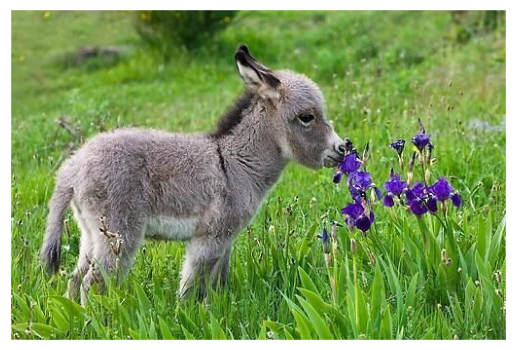

In [29]:
import matplotlib.image as mpimg
from otter.export import export_notebook
from os import path
from IPython.display import display, HTML
export_notebook("lab03.ipynb", filtering=True, pagebreaks=True)
if(path.exists('lab03.pdf')):
    img = mpimg.imread('baby_donkey.jpg')
    imgplot = plt.imshow(img)
    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)
    plt.show()
    display(HTML("Download your PDF <a href='lab03.pdf' download>here</a>."))

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [27]:
grader.check_all()

q1a_i results: All test cases passed!

q1b results: All test cases passed!

q1c results: All test cases passed!

q2a results: All test cases passed!

q2b results: All test cases passed!

q2d results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit.

In [28]:
grader.export(pdf=False, force_save=True)

<IPython.core.display.Javascript object>